# Boosting-based estimator

In [36]:
# temporary fix to avoid spurious warning raised in scikit-learn 1.0.0
# it will be solved in scikit-learn 1.0.1
import warnings
warnings.filterwarnings("ignore", message="X has feature names.*")
warnings.filterwarnings("ignore", message="X does not have valid feature names.*")

## Introduction to boosting

In [37]:
import pandas as pd

data = pd.read_csv("../datasets/penguins_classification.csv")
data["Species"] = data["Species"].astype("category")
data.head()

X, y = data[["Culmen Length (mm)", "Culmen Depth (mm)"]], data["Species"]

In [38]:
import seaborn as sns
sns.set_context("poster")

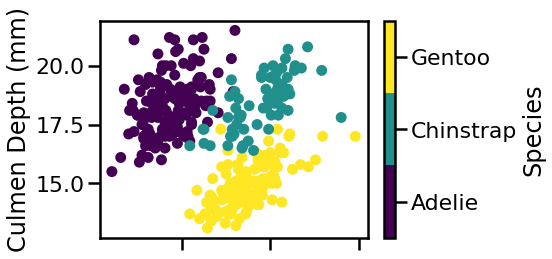

In [39]:
import matplotlib.pyplot as plt

_ = data.plot.scatter(
    x="Culmen Length (mm)",
    y="Culmen Depth (mm)",
    c="Species",
    s=80,
    cmap=plt.cm.viridis,
)

In [40]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=2, random_state=0)
tree.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=0)

In [41]:
import numpy as np

target_predicted = tree.predict(X)
mask_misclassified = y != target_predicted

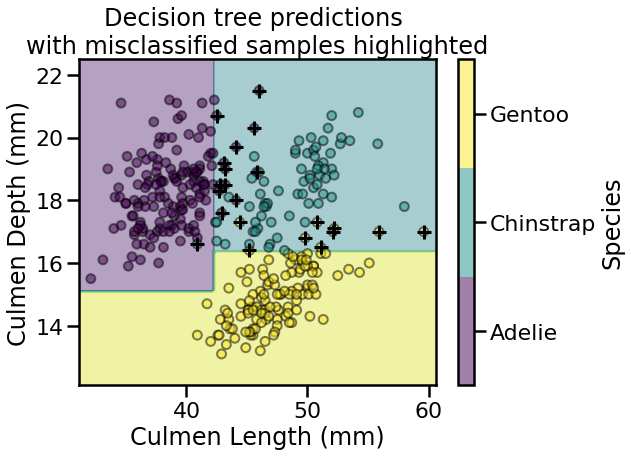

In [42]:
from helper.plotting import DecisionBoundaryDisplay

_, ax = plt.subplots(figsize=(8, 6))

# plot the decision boundaries
display = DecisionBoundaryDisplay.from_estimator(
    tree, X, response_method="predict", cmap=plt.cm.viridis,
    alpha=0.4, ax=ax,
)

# plot the original dataset
data.plot.scatter(
    x="Culmen Length (mm)",
    y="Culmen Depth (mm)",
    c="Species",
    s=80,
    cmap=plt.cm.viridis,
    alpha=0.5,
    edgecolor="black",
    ax=ax,
)
# plot the misclassified samples
data[mask_misclassified].plot.scatter(
    x="Culmen Length (mm)",
    y="Culmen Depth (mm)",
    c="black",
    s=200,
    marker="+",
    ax=ax,
)

_ = plt.title("Decision tree predictions \nwith misclassified samples "
              "highlighted")

In [43]:
sample_weight = np.zeros_like(y, dtype=np.float64)
sample_weight[mask_misclassified] = 1

tree = DecisionTreeClassifier(max_depth=2, random_state=0)
tree.fit(X, y, sample_weight=sample_weight)

DecisionTreeClassifier(max_depth=2, random_state=0)

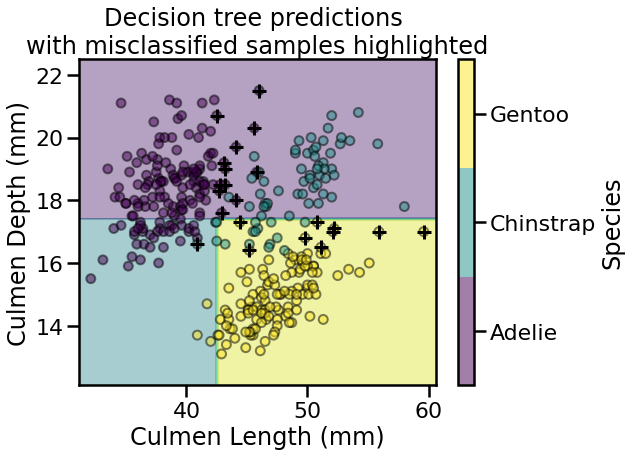

In [44]:
_, ax = plt.subplots(figsize=(8, 6))

# plot the decision boundaries
display = DecisionBoundaryDisplay.from_estimator(
    tree, X, response_method="predict", cmap=plt.cm.viridis,
    alpha=0.4,
    ax=ax,
)

# plot the original dataset
data.plot.scatter(
    x="Culmen Length (mm)",
    y="Culmen Depth (mm)",
    c="Species",
    s=80,
    cmap=plt.cm.viridis,
    alpha=0.5,
    edgecolor="black",
    ax=ax,
)
# plot the misclassified samples
data[mask_misclassified].plot.scatter(
    x="Culmen Length (mm)",
    y="Culmen Depth (mm)",
    c="black",
    s=200,
    marker="+",
    ax=ax,
)

_ = plt.title("Decision tree predictions \nwith misclassified samples "
              "highlighted")

In [45]:
target_predicted = tree.predict(X)
mask_new_misclassifier = y != target_predicted
remaining_misclassified_samples_idx = (
    mask_misclassified & mask_new_misclassifier
)

print(f"Number of samples previously misclassified and "
      f"still misclassified: {remaining_misclassified_samples_idx.sum()}")

Number of samples previously misclassified and still misclassified: 0


In [46]:
ensemble_weight = [
    (y.size - mask_misclassified.sum()) / y.size,
    (y.size - mask_new_misclassifier.sum()) / y.size,
]
ensemble_weight



[0.935672514619883, 0.6929824561403509]

In [47]:
from sklearn.ensemble import AdaBoostClassifier

base_estimator = DecisionTreeClassifier(max_depth=3, random_state=0)
adaboost = AdaBoostClassifier(
    base_estimator=base_estimator,
    n_estimators=3, algorithm="SAMME",
    random_state=0
)
adaboost.fit(X, y)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=0),
                   n_estimators=3, random_state=0)

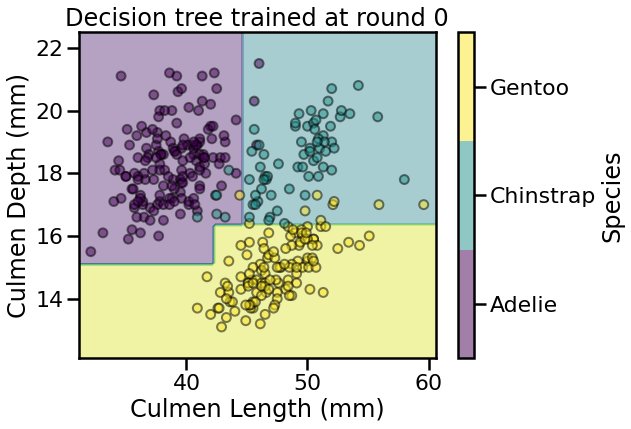

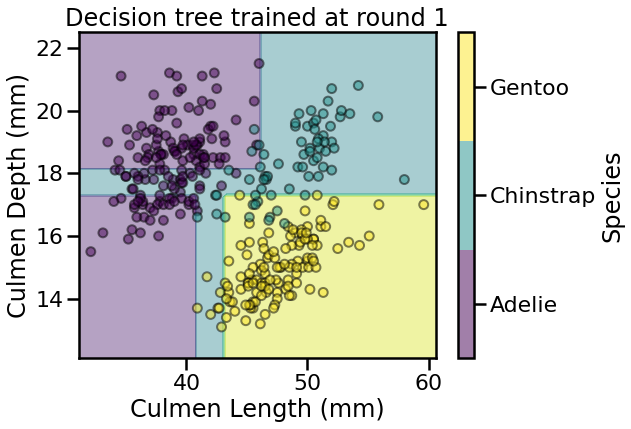

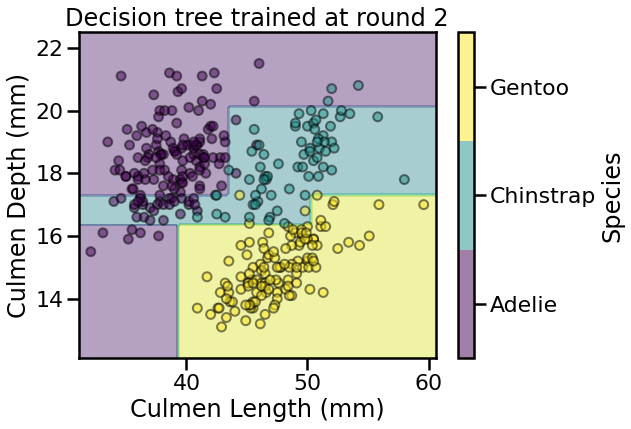

In [48]:
for boosting_round, tree in enumerate(adaboost.estimators_):
    _, ax = plt.subplots(figsize=(8, 6))
    display = DecisionBoundaryDisplay.from_estimator(
        tree, X, response_method="predict", cmap=plt.cm.viridis,
        alpha=0.4,
        ax=ax,
    )
    data.plot.scatter(
        x="Culmen Length (mm)",
        y="Culmen Depth (mm)",
        c="Species",
        s=80,
        cmap=plt.cm.viridis,
        alpha=0.5,
        edgecolor="black",
        ax=ax,
    )
    _ = ax.set_title(f"Decision tree trained at round {boosting_round}")

In [49]:
print(f"Weight of each classifier: {adaboost.estimator_weights_}")

Weight of each classifier: [3.58351894 3.46901998 3.03303773]


In [ ]:
print(f"Error of each classifier: {adaboost.estimator_errors_}")

## Gradient Boosting Decision Trees

### Introduction

Another Ensemble method that can be useful is *Boosting*: here, rather than
looking at 200 (say) parallel estimators, we construct a chain of 200 estimators
which iteratively refine the results of the previous estimator.
The idea is that by sequentially applying very fast, simple models, we can get a
total model error which is better than any of the individual pieces.

In [54]:
data = pd.read_csv("../datasets/adult-census-numeric-all.csv")
data.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,class
0,25,7,0,0,40,<=50K
1,38,9,0,0,50,<=50K
2,28,12,0,0,40,>50K
3,44,10,7688,0,40,>50K
4,18,10,0,0,30,<=50K


In [55]:
X, y = data.drop(columns="class"), data["class"]

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0
)

In [67]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=200)
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.8473151156124594
0.8433379739579068
CPU times: user 2.11 s, sys: 13.8 ms, total: 2.13 s
Wall time: 2.13 s


### Accelerate gradient boosting

<div class="alert alert-success">
    <b>ACCELERATE GRADIENT BOOSTING</b>:
    <ul>
        <li>Which solution would you use to accelerate the training speed of gradient boosting algorithm.</li>
    </ul>
</div>

In [68]:
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(
    n_bins=256, encode="ordinal", strategy="quantile")
X_trans = discretizer.fit_transform(X)
X_trans

/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:235: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:235: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:235: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:235: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing t

array([[ 8.,  6.,  0.,  0., 24.],
       [21.,  8.,  0.,  0., 33.],
       [11., 11.,  0.,  0., 24.],
       ...,
       [42.,  8.,  0.,  0., 24.],
       [ 5.,  8.,  0.,  0., 10.],
       [35.,  8., 16.,  0., 24.]])

In [69]:
[len(np.unique(col)) for col in X_trans.T]

[57, 15, 18, 10, 43]

In [73]:
%%time
from sklearn.pipeline import make_pipeline

clf = make_pipeline(
    discretizer, GradientBoostingClassifier(n_estimators=200))
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:235: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:235: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:235: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:235: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing t

0.8401627037208922
0.8358037834739169
CPU times: user 2.11 s, sys: 17.9 ms, total: 2.13 s
Wall time: 2.13 s


Scikit-learn provides `HistGradientBoostingClassifier` which is an approximate gradient boosting algorithm similar to `lightgbm` and `xgboost`.

In [61]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier(max_iter=100)
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.8506456280199831
0.8430104004586029
CPU times: user 5.88 s, sys: 2.58 s, total: 8.46 s
Wall time: 1.3 s


### Hyperparameters

For gradient-boosting, parameters are coupled, so we cannot set the parameters one after the other anymore. The important parameters are `n_estimators`, `max_depth`, and `learning_rate`.